In [1]:
import sys
sys.path.append("src")

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict, List

from src.custom_types import DataFrame
from src.utils.utils import add_columns, parse_config
from src.utils.env import ENV
from src.utils.safe_io import load_data

%matplotlib inline


In [3]:
fig_size = (8, 5)
sns.color_palette("Spectral", as_cmap=True)

df_state = gpd.read_file('data/tl_2021_us_state.shp')
excludes = ['VI', 'MP', 'GU', 'AS', 'PR']
df_state = df_state[~df_state.STUSPS.isin(excludes)]
plot_kwargs = {'grid': False, 'figsize': fig_size, 'legend': False}



In [4]:
parse_config()


def get_dfs() -> Dict[str, DataFrame]:
    dfs: Dict[str, DataFrame] = {}
    for data_name, eda_info in ENV.CONFIG['eda'].items():
        dfs[data_name] = load_data(data_name)
        if extra_columns := eda_info.get('extra_columns'):
            dfs[data_name] = add_columns(dfs[data_name], extra_columns)
    return dfs


def groupby_state(df: DataFrame, column: str, label: str) -> DataFrame:
    df_group = df.groupby('customer_state')[column] \
        .count() \
        .to_frame()
    plot_map(df_group, column, label)
    return df_group

def plot_map(df: DataFrame, column: str, label: str, cmap: str = 'BuGn'):
    df = df_state.set_index('STUSPS') \
        .merge(df, left_index=True, right_index=True, how='left') \
        .fillna(0)

    x_boundary = (-180, -65)
    ax = df.plot(column=column, cmap=cmap, figsize=fig_size)
    ax.set_xlim(x_boundary)
    ax.set_axis_off()

    color_min_max = {
        'vmin': df.loc[:, column].min(),
        'vmax': df.loc[:, column].max()
    }
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(**color_min_max))
    color_bar = plt.colorbar(sm)
    color_bar.set_label(label, rotation=270, labelpad=13)

    print(df.sort_values(column, ascending=False)
          [['NAME', column]].head())
    print(df.sort_values(column)[['NAME', column]].head())

def to_datetime_columns(df: DataFrame, columns: List[str]):
    for col in columns:
        df.loc[:, col] = pd.to_datetime(df.loc[:, col])

In [5]:
dfs = get_dfs()

df_customer = dfs['customers']
df_order = dfs['orders']
df_payment = dfs['payments']
df_item = dfs['items']
print(df_item[df_item.price < 0].shape)
df_item = df_item[df_item.price >= 0]
print(df_item[df_item.freight_value < 0].shape)
df_item.loc[:, 'freight_value'] = df_item.freight_value.clip(0)

(10, 9)
(270, 9)


C:\Users\wvjgsuhp\AppData\Local\Temp\ipykernel_6052\2959370926.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_item.loc[:, 'freight_value'] = df_item.freight_value.clip(0)


In [6]:
df_customer.shape[0], df_order.shape[0], df_payment.shape[0], df_item.shape[0]

(99441, 99441, 103886, 112640)

# EDA
**Demographic**

,customer_state
customer_state,
1,0.015349
2,0.905239
3,0.063397
4,0.010344
5,0.002336
6,0.002002
7,0.000667
8,0.000334
17,0.000334


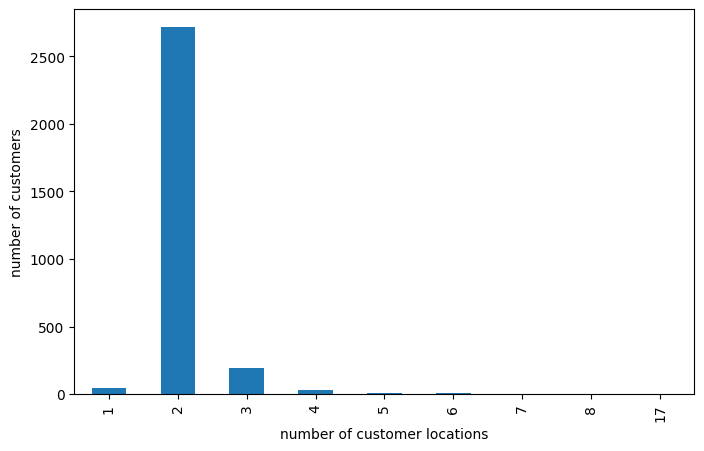

In [7]:
duplicated = df_customer.customer_unique_id.duplicated(keep=False)
df_duplicated_customer = df_customer[duplicated].sort_values('customer_unique_id') \
    .groupby(['customer_unique_id']) \
    .customer_state \
    .nunique() \
    .to_frame() \
    .groupby('customer_state') \
    .customer_state \
    .count() \
    .to_frame()

ax = df_duplicated_customer.plot(kind='bar', figsize=fig_size, legend=False)
ax.set_xlabel('number of customer locations')
ax.set_ylabel('number of customers')

df_duplicated_customer / df_duplicated_customer.sum()

In [8]:
print(df_customer.shape[0], df_customer.customer_id.unique().shape[0], df_customer.customer_unique_id.unique().shape[0])
df_customer[duplicated].sort_values('customer_unique_id').head()

99441 99441 96096


,customer_id,customer_unique_id,customer_city,customer_state,customer_zip_code
35608,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,Deborahborough,NJ,8605
19299,1afe8a9c67eec3516c09a8bdcc539090,00172711b30d52eea8b313a7f2cced02,Wilkinsonville,OR,97244
20023,1b4a75b3478138e99902678254b260f4,004288347e5e88a27ded2bb23747066c,Priceton,IN,47773
22066,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,Jacksonburgh,NY,12971
72451,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,Cherylport,OK,73038


In [9]:
df_customer.nunique()

customer_id           99441
customer_unique_id    96096
customer_city         38038
customer_state           51
customer_zip_code     50545
dtype: int64

In [10]:
df_customer.groupby('customer_city').customer_city.count().sort_values(ascending=False).head()

customer_city
Port Michael     90
New Michael      84
South Michael    81
West Michael     80
East Michael     79
Name: customer_city, dtype: int64

                 NAME  customer_state
STUSPS                               
HI             Hawaii            2037
WV      West Virginia            2028
IA               Iowa            2028
UT               Utah            2015
AL            Alabama            2014
                NAME  customer_state
STUSPS                              
CT       Connecticut            1864
CA        California            1878
RI      Rhode Island            1879
OR            Oregon            1880
MI          Michigan            1893


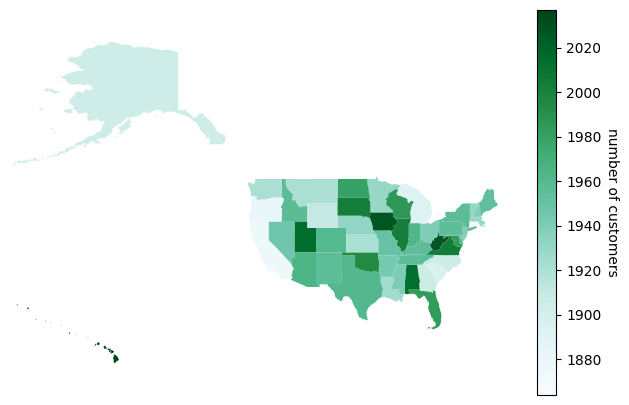

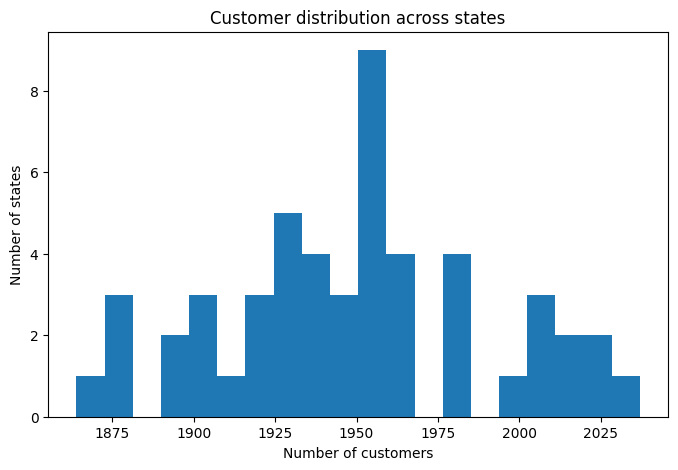

In [11]:
df_customer_state = groupby_state(
    df_customer, 'customer_state', 'number of customers')
ax = df_customer_state.rename(columns={'customer_state': 'n_customers'}) \
    .reset_index() \
    .plot('customer_state', 'n_customers', kind='hist', bins=20, **plot_kwargs)
ax.set_xlabel('Number of customers')
ax.set_ylabel('Number of states')
ax.set_title('Customer distribution across states')
plt.show()


## Orders

In [12]:
print('# orders:', df_item.order_id.unique().shape[0])
print('# items:', df_item.shape[0])
df_item.head(3)

# orders: 98664
# items: 112640


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,price_over_freight,total_price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2020-09-19 09:45:35,56.9,12.29,4.629780,69.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2020-05-03 11:05:13,237.9,18.93,12.567353,256.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2021-01-18 14:48:30,197.0,16.87,11.677534,213.87


In [13]:
print('# customers:', df_order.customer_id.unique().shape[0])
print('# orders:', df_order.shape[0])
df_order.head(3)

# customers: 99441
# orders: 99441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2020-10-02 10:56:33,2020-10-02 11:07:15,2020-10-04 19:55:00,2020-10-10 21:25:13,2020-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2021-07-24 20:41:37,2021-07-26 03:24:27,2021-07-26 14:31:00,2021-08-07 15:27:45,2021-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2021-08-08 08:38:49,2021-08-08 08:55:23,2021-08-08 13:50:00,2021-08-17 18:06:29,2021-09-04


In [14]:
print('# orders:', df_payment.order_id.unique().shape[0])
print('# payments:', df_payment.shape[0])
print('# initial payments:', df_payment[df_payment.payment_sequential == 1].shape[0])
df_payment.head(3)

# orders: 99440
# payments: 103886
# initial payments: 99360


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,101.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,22.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,66.71


In [15]:
datetime_columns = [
    'order_estimated_delivery_date', 'order_delivered_customer_date',
    'order_delivered_carrier_date', 'order_approved_at',
    'order_purchase_timestamp']
to_datetime_columns(df_order, datetime_columns)
delivery_time = (df_order.order_delivered_customer_date -
                 df_order.order_purchase_timestamp) / np.timedelta64(1, 'D')
df_order = df_order.assign(delivery_time=delivery_time)


def get_is_late(columns: str) -> pd.Series:
    column = columns.pop(0)
    date_column = df_order.loc[:, column]
    is_late = (date_column - df_order.order_estimated_delivery_date).dt.days > 0
    if not columns:
        return np.where(is_late, True, np.nan)
    if column == 'order_delivered_customer_date':
        return np.where(date_column.notna(), is_late, get_is_late(columns))

    return np.where(is_late, True, get_is_late(columns))


is_late = get_is_late(datetime_columns[1:])
df_order = df_order.assign(is_late=is_late)
purchase_time = df_order.order_purchase_timestamp.dt.hour + df_order.order_purchase_timestamp.dt.minute / 60
df_order = df_order.assign(purchase_time=purchase_time)

df_order.head(3)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,is_late,purchase_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2020-10-02 10:56:33,2020-10-02 11:07:15,2020-10-04 19:55:00,2020-10-10 21:25:13,2020-10-18,8.436574,0.0,10.933333
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2021-07-24 20:41:37,2021-07-26 03:24:27,2021-07-26 14:31:00,2021-08-07 15:27:45,2021-08-13,13.782037,0.0,20.683333
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2021-08-08 08:38:49,2021-08-08 08:55:23,2021-08-08 13:50:00,2021-08-17 18:06:29,2021-09-04,9.394213,0.0,8.633333


In [16]:
df_payment_status = df_payment.groupby('order_id') \
    .order_id \
    .count() \
    .to_frame() \
    .rename(columns={'order_id': 'payment_count'}) \
    .reset_index() \
    .merge(df_payment[df_payment.payment_sequential == 1], on='order_id')

payment_status = np.where(df_payment_status.payment_installments == 1,
                          'payment complete', np.where(
                              df_payment_status.payment_installments <=
                              df_payment_status.payment_count,
                              'installment complete', 'installment incomplete'))
df_payment_status = df_payment_status.assign(payment_status=payment_status)
df_payment_status.head()

df_payment_status.groupby('payment_status').payment_status.count()


payment_status
installment complete        297
installment incomplete    50827
payment complete          48236
Name: payment_status, dtype: int64

                 NAME  order_status
STUSPS                             
HI             Hawaii          2037
WV      West Virginia          2028
IA               Iowa          2028
UT               Utah          2015
AL            Alabama          2014
                NAME  order_status
STUSPS                            
CT       Connecticut          1864
CA        California          1878
RI      Rhode Island          1879
OR            Oregon          1880
MI          Michigan          1893


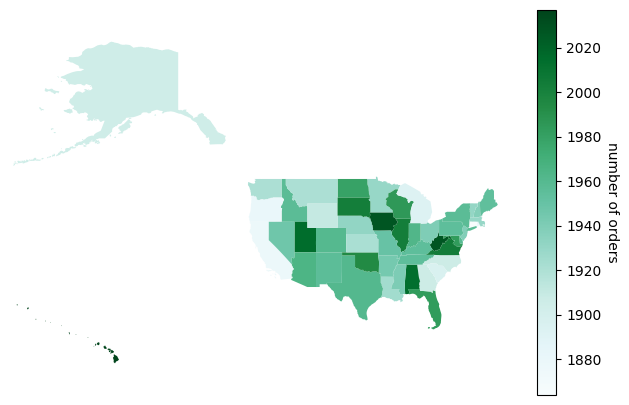

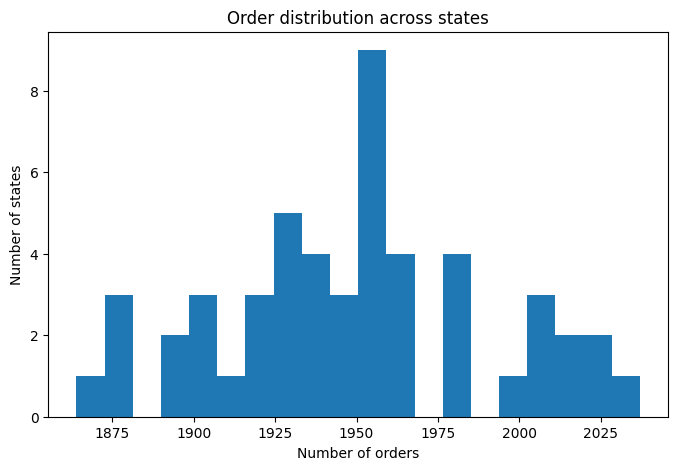

In [17]:
df_customer_order = df_customer.merge(df_order, on='customer_id', how='inner')
df_state_order = groupby_state(df_customer_order, 'order_status', 'number of orders')

ax = df_state_order.reset_index() \
    .plot('customer_state', 'order_status', kind='hist', bins=20, **plot_kwargs)
ax.set_xlabel('Number of orders')
ax.set_ylabel('Number of states')
ax.set_title('Order distribution across states')
plt.show()


                 NAME  order_id
STUSPS                         
HI             Hawaii      2321
WV      West Virginia      2311
IA               Iowa      2303
AL            Alabama      2295
UT               Utah      2286
               NAME  order_id
STUSPS                       
CT      Connecticut      2094
WY          Wyoming      2113
OR           Oregon      2120
CA       California      2124
KS           Kansas      2126


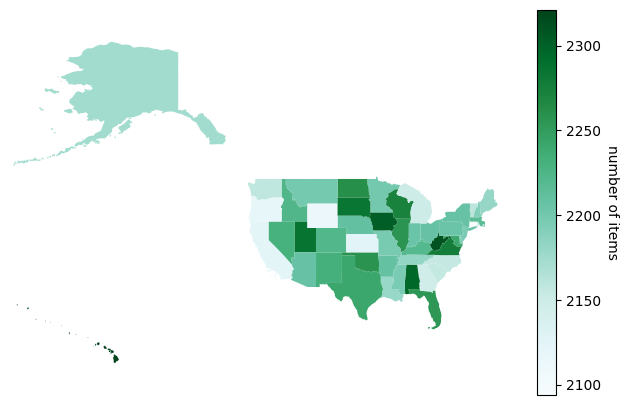

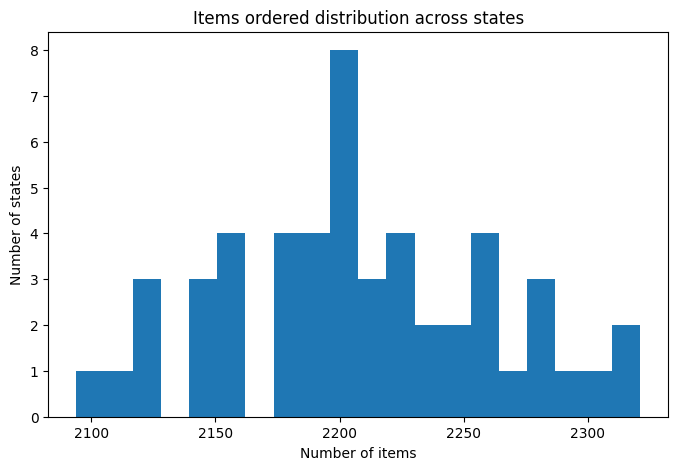

In [18]:
df_customer_item = df_customer.merge(df_order, on='customer_id', how='inner') \
    .loc[:, ['customer_id', 'order_id', 'customer_state']] \
    .merge(df_item, on='order_id', how='inner')
df_state_item = groupby_state(df_customer_item, 'order_id', 'number of items')

ax = df_state_item.reset_index() \
    .plot('customer_state', 'order_id', kind='hist', bins=20, **plot_kwargs)
ax.set_xlabel('Number of items')
ax.set_ylabel('Number of states')
ax.set_title('Items ordered distribution across states')
plt.show()


            NAME  total_price
STUSPS                       
IN       Indiana   167.683294
OR        Oregon   167.497422
AZ       Arizona   166.944617
CO      Colorado   165.234242
OK      Oklahoma   165.201608
                 NAME  total_price
STUSPS                            
WA         Washington   143.591139
NH      New Hampshire   148.039279
MI           Michigan   148.332150
VA           Virginia   149.163707
UT               Utah   151.627252


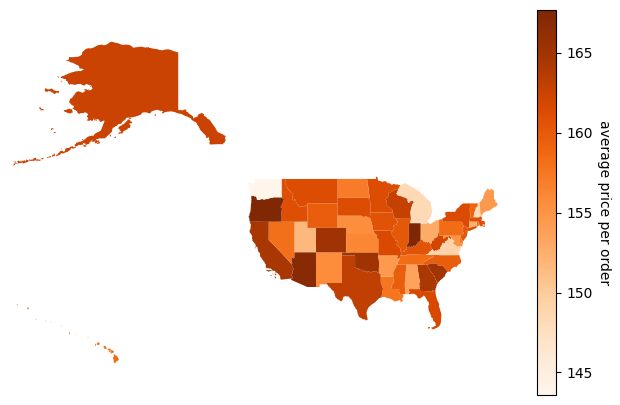

In [19]:
order_agg = {'customer_id': 'first', 'customer_state': 'first', 'total_price': 'sum'}
df_state_total_price = df_customer_item.groupby('order_id') \
    .agg(order_agg) \
    .groupby('customer_state') \
    .total_price \
    .mean() \
    .to_frame()
plot_map(df_state_total_price, 'total_price', 'average price per order', cmap='Oranges')


               NAME  total_price
STUSPS                          
CA       California      110.830
AK           Alaska      107.910
CO         Colorado      106.620
MS      Mississippi      106.600
DE         Delaware      106.435
               NAME  total_price
STUSPS                          
CT      Connecticut        99.06
NE         Nebraska       100.51
MD         Maryland       100.59
AR         Arkansas       100.64
FL          Florida       100.85


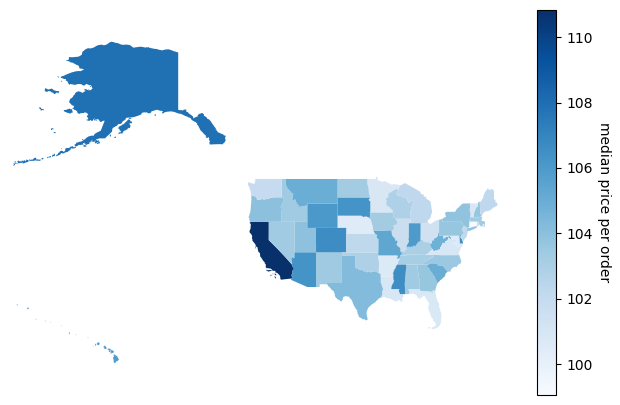

In [20]:
order_agg = {'customer_id': 'first', 'customer_state': 'first', 'total_price': 'sum'}
df_state_median_price = df_customer_item.groupby('order_id') \
    .agg(order_agg) \
    .groupby('customer_state') \
    .total_price \
    .median() \
    .to_frame()
plot_map(df_state_median_price, 'total_price', 'median price per order', cmap='Blues')


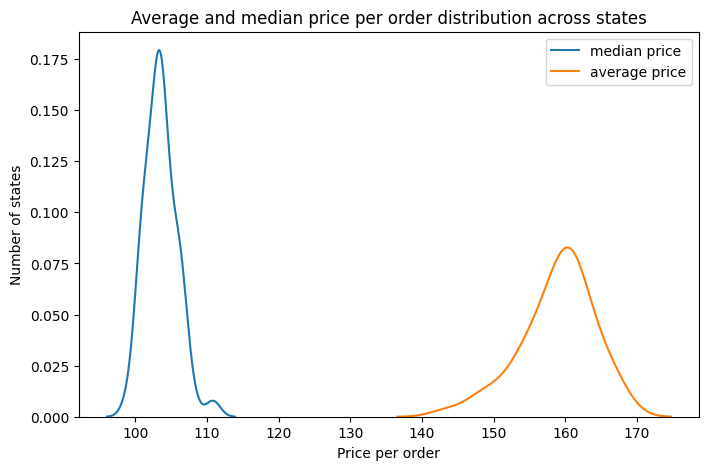

In [21]:
plt.figure(figsize=fig_size)
sns.kdeplot(df_state_median_price.rename(columns={'total_price': 'median price'}).squeeze())
sns.kdeplot(df_state_total_price.rename(columns={'total_price': 'average price'}).squeeze())
plt.xlabel('Price per order')
plt.ylabel('Number of states')
plt.legend(['median price', 'average price'])
plt.title('Average and median price per order distribution across states')
plt.show()

                  NAME  delivery_time
STUSPS                               
RI        Rhode Island      13.064070
IA                Iowa      12.914422
NC      North Carolina      12.832987
WA          Washington      12.819991
CO            Colorado      12.804176
              NAME  delivery_time
STUSPS                           
AR        Arkansas      12.197573
VA        Virginia      12.199774
NJ      New Jersey      12.305448
IN         Indiana      12.317275
NE        Nebraska      12.337002


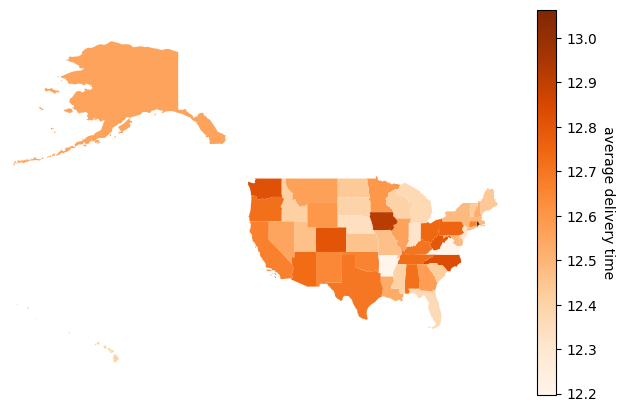

In [22]:
df_mean_delivery = df_customer_order.groupby('customer_state') \
    .delivery_time \
    .mean() \
    .to_frame()
plot_map(df_mean_delivery, 'delivery_time', 'average delivery time', cmap='Oranges')


              NAME  delivery_time
STUSPS                           
AL         Alabama      10.682928
CA      California      10.663958
WY         Wyoming      10.586956
TX           Texas      10.586337
OR          Oregon      10.468148
               NAME  delivery_time
STUSPS                            
NV           Nevada       9.904109
IN          Indiana       9.952813
ME            Maine       9.979329
KS           Kansas       9.998322
MS      Mississippi      10.001881


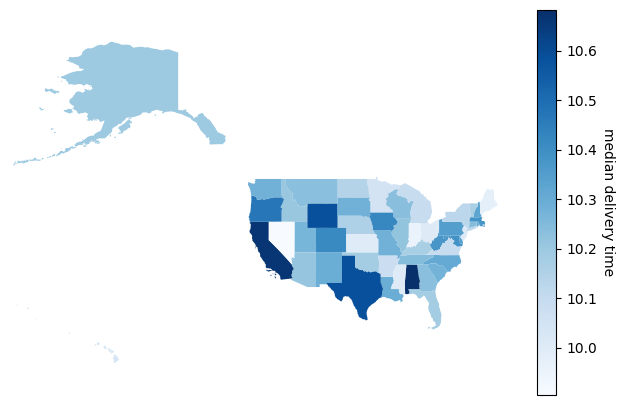

In [23]:
df_median_delivery = df_customer_order.groupby('customer_state') \
    .delivery_time \
    .median() \
    .to_frame()
plot_map(df_median_delivery, 'delivery_time', 'median delivery time', cmap='Blues')


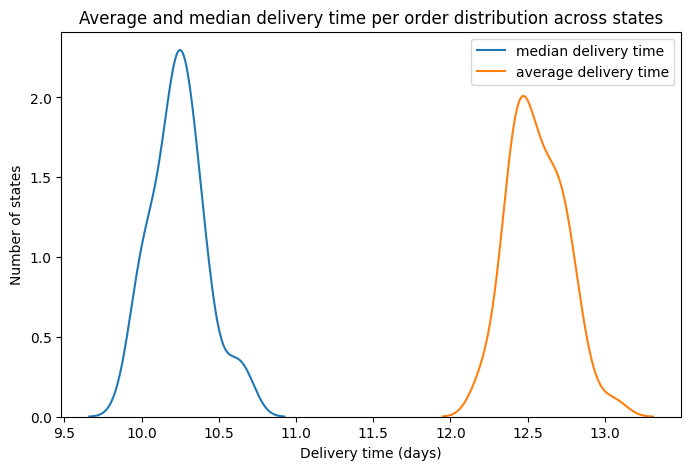

In [24]:
plt.figure(figsize=fig_size)
sns.kdeplot(df_median_delivery.rename(columns={'delivery_time': 'median delivery time'}).squeeze())
sns.kdeplot(df_mean_delivery.rename(columns={'delivery_time': 'average delivery time'}).squeeze())
plt.xlabel('Delivery time (days)')
plt.ylabel('Number of states')
plt.legend(['median delivery time', 'average delivery time'])
plt.title('Average and median delivery time per order distribution across states')
plt.show()

                 NAME  is_late
STUSPS                        
RI       Rhode Island      155
WA         Washington      144
ME              Maine      144
WV      West Virginia      141
IL           Illinois      141
                NAME  is_late
STUSPS                       
NE          Nebraska       98
WI         Wisconsin      112
PA      Pennsylvania      113
WY           Wyoming      117
ID             Idaho      118


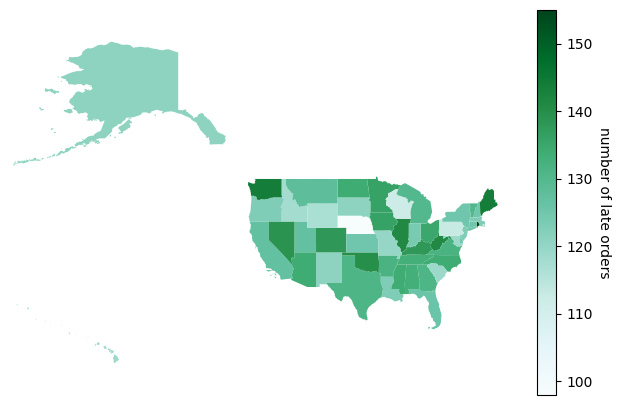

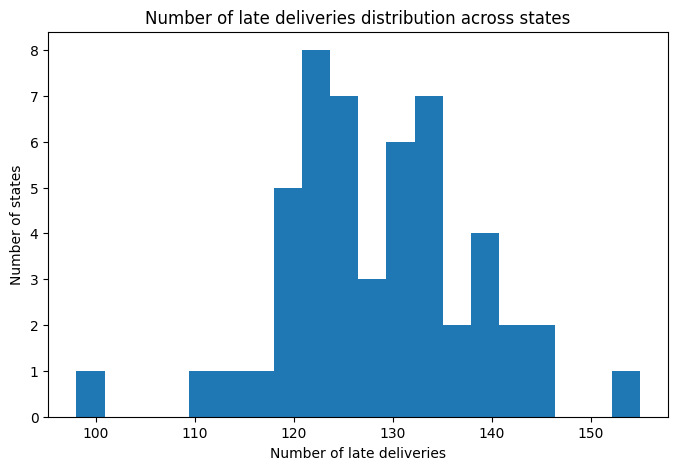

In [25]:
df_state_late = df_customer.merge(df_order[df_order.is_late == 1], on='customer_id', how='inner') \
    .merge(df_item.drop_duplicates(['order_id']), on='order_id', how='inner')
df_state_late = groupby_state(df_state_late, 'is_late', 'number of late orders')

ax = df_state_late.reset_index() \
    .plot('customer_state', 'is_late', kind='hist', bins=20, **plot_kwargs)
ax.set_xlabel('Number of late deliveries')
ax.set_ylabel('Number of states')
ax.set_title('Number of late deliveries distribution across states')
plt.show()

                        NAME  purchase_time
STUSPS                                     
DC      District of Columbia      16.183333
NE                  Nebraska      15.833333
NJ                New Jersey      15.800000
AR                  Arkansas      15.791667
NH             New Hampshire      15.775000
             NAME  purchase_time
STUSPS                          
NV         Nevada      15.050000
AK         Alaska      15.200000
TN      Tennessee      15.233333
ME          Maine      15.266667
KS         Kansas      15.275000


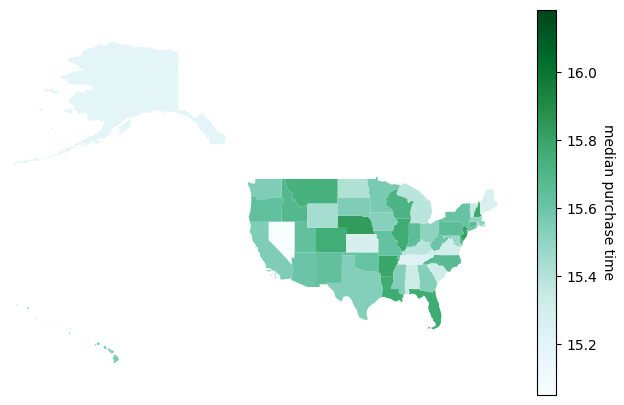

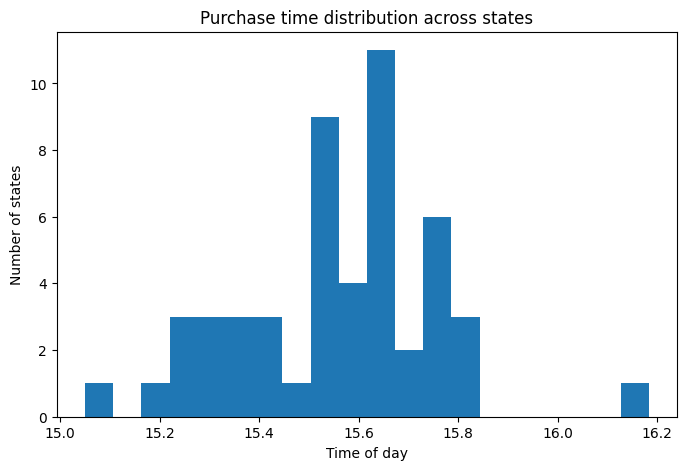

In [26]:
df_median_purchase_time = df_customer_order.groupby('customer_state') \
    .purchase_time \
    .median() \
    .to_frame()
plot_map(df_median_purchase_time, 'purchase_time', 'median purchase time')

ax = df_median_purchase_time.reset_index() \
    .plot('customer_state', 'purchase_time', kind='hist', bins=20, **plot_kwargs)
ax.set_xlabel('Time of day')
ax.set_ylabel('Number of states')
ax.set_title('Purchase time distribution across states')
plt.show()

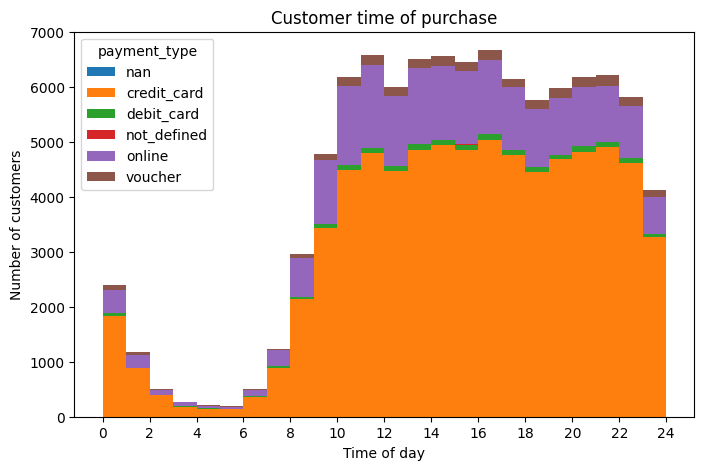

In [27]:
df_ = df_customer_order.merge(
    df_payment[['order_id', 'payment_type']].drop_duplicates(
        subset=['order_id']),
    on='order_id', how='left')[
    ['purchase_time', 'payment_type']]
df_.loc[99441] = [24, np.nan]
ax = df_.pivot(columns='payment_type').purchase_time.plot(
    kind='hist', stacked=True,  bins=24, figsize=fig_size, grid=False)
ax.set_xlabel('Time of day')
ax.set_ylabel('Number of customers')
ax.set_title('Customer time of purchase')
plt.xticks(range(0, 25, 2))
plt.show()


                NAME  customer_id
STUSPS                           
WI         Wisconsin          998
WA        Washington          986
IA              Iowa          985
ND      North Dakota          981
AZ           Arizona          979
               NAME  customer_id
STUSPS                          
CA       California          881
AK           Alaska          890
CT      Connecticut          893
WY          Wyoming          894
NJ       New Jersey          895


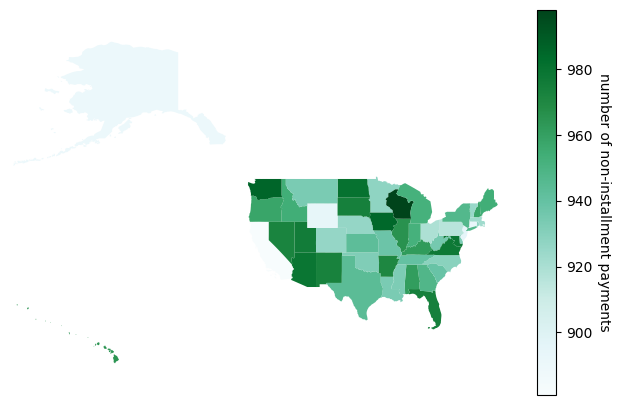

In [28]:
df_non_installment_customer = df_payment_status[df_payment_status.payment_status == 'payment complete'].merge(df_order, on='order_id', how='left') \
    .merge(df_customer, on='customer_id', how='inner')
_ = groupby_state(df_non_installment_customer, 'customer_id', 'number of non-installment payments')


                 NAME  customer_id
STUSPS                            
WV      West Virginia         1093
HI             Hawaii         1071
OK           Oklahoma         1060
AL            Alabama         1048
NJ         New Jersey         1044
                  NAME  customer_id
STUSPS                             
OR              Oregon          922
WA          Washington          933
MI            Michigan          940
RI        Rhode Island          949
SC      South Carolina          957


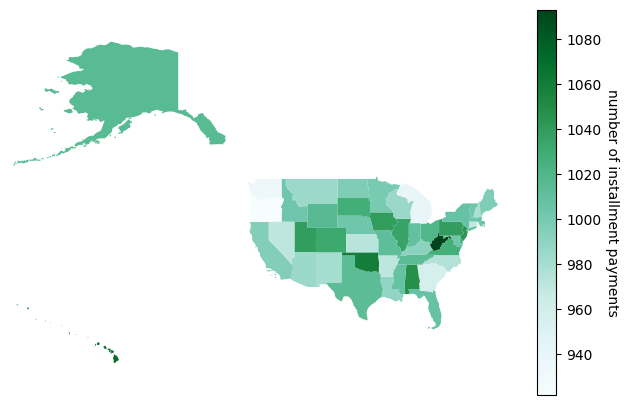

In [29]:
df_installment_customer = df_payment_status[df_payment_status.payment_status != 'payment complete'].merge(df_order, on='order_id', how='left') \
    .merge(df_customer, on='customer_id', how='inner')
_ = groupby_state(df_installment_customer, 'customer_id', 'number of installment payments')


In [30]:
df_order.groupby('order_status').order_status.count()

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
Name: order_status, dtype: int64